<a href="https://colab.research.google.com/github/PyMap/AUPY/blob/master/Modulo%203/03_5_deflactar_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grandes volúmenes de datos



## [Properati](https://blog.properati.com.ar/category/contenidos-data/), un ejemplo aplicado al mundo del real estate ... 

Como científico de datos urbanos, una dimensión de interés es lo que sucede en el mundo de la vivienda. Al menos aquella que circula dentro de un mercado formal.

Construir nuestros propios índices de precios y seguirlos a lo largo de un período, evaluar la distribución espacial de las distintas tipologías o incluso estudiar los niveles de inflación. Todas, preguntas que podríamos llegar a hacernos frente a un análisis que involucre a la viviendas como nuestro objeto de estudio.

La noción de BigData puede ser a veces un poco difusa. Sin embargo, no queda duda que este concepto está innegablemente ligado a la noción de tiempo. Más datos suceden en más tiempo. Por eso, aprender a trabajar con conjuntos de datos administrados, accesibles a lo largo del tiempo es tan importante. Porque nos abre las puertas a grandes cantidades de información.

El portal inmobiliario `properati` 🏢 es un buen caso de uso para hablar de Big Data y ciencia de datos urbanos. Gracias al gran trabajo que hacen, se contar con una fuente que se actualiza constantemente y que nos permite hacer nuestros propios análisis. Por eso, no dejen de citarlos cada vez que usan los recursos que comparten 🚀.  

### El conjunto de datos 

Properati almacena sus registros de publicaciones en distintos conjuntos de datos. Todos ellos correspondientes a múltiples países de latinoamérica (algo también interesante, no?). Imagínense todas las preguntas que podríamos responder, o rutinas que podríamos estandarizar para construir nuestra propia información.

Para esta clase, vamos a trabajar con uno de los extractos descargable en formato csv. L@s que estén interesados en ver cómo funcionan las consultas en la consola de google cloud utilizando Big Query puede ir al material complementario. Como decíamos, estos extractos son porciones organizadas en fechas que se actualizan diariamente. Con el que trabajaremos corresponde a argentina. 

Cada tabla correspondiente al conjunto de datos de cada país tiene el siguiente esquema:


* **ad_type** - Tipo de aviso (Propiedad, Desarrollo).
* **id** - Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas.
* **start_date** - Fecha de alta del aviso.
* **end_date** - Fecha de baja del aviso.
* **created_on** - Fecha de alta de la primera versión del aviso.
* **place** - Campos referidos a la ubicación de la propiedad o del desarrollo.
  * **lat** - Latitud.
  * **lon** - Longitud.
  * **l1** - Nivel geopolítico 1: país.
  * **l2** - Nivel geopolítico 2: usualmente provincia.
  * **l3** - Nivel geopolítico 3: usualmente ciudad/localidad.
  * **l4 a l6** - Niveles geopolíticos 4 a 6: usualmente barrio.
* **property** - Campos relativos a la propiedad (vacío si el aviso es de un desarrollo).
  * **operation_type** - Tipo de operación (Venta, Alquiler y Alquiler temporal ).
  * **property_type** - Tipo de propiedad (Casa, Departamento, PH, etc.).
  * **rooms** - Cantidad de ambientes (útil en Argentina).
  * **bedrooms** - Cantidad de dormitorios (útil en el resto de los países).
  * **bathrooms** - Cantidad de baños.
  * **surface_total** - Superficie total en m².
  * **surface_covered** - Superficie cubierta en m².
  * **price** - Precio publicado en el anuncio.
  * **currency** - Moneda del precio publicado.
  * **price_period** - Periodo del precio (Diario, Semanal, Mensual)
  * **title** - Título del anuncio.
  * **description** - Descripción del anuncio.


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://storage.googleapis.com/python_mdg/data_cursos/ar_properties.csv.gz')

In [3]:
df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

## Fechas, días y el uso de `datetime`

**Datetime** es un modulo de pandas diseñado para manipular fechas y horas. Las clases que provee permite tanto operaciones aritméticas como la extraccion de campos como dia, mes, fecha y hora de una manera rapida y eficiente.

In [4]:
# importamos el modulo
from datetime import datetime

In [5]:
df.start_date[0]

'2021-01-17'

In [6]:
# convirtamos el primer registro de la serie Fecha a dias. Esto nos devolvera un valor posicional
datetime.strptime(df.start_date[0],'%Y-%m-%d').weekday()

6

In [7]:
 # Y obtengamos el dia de la semana para todo el dataset
dia_semana = df.start_date.apply(lambda x: datetime.strptime(x,'%Y-%m-%d').weekday())

In [8]:
dia_semana

0         6
1         6
2         6
3         6
4         6
         ..
999995    3
999996    3
999997    3
999998    3
999999    3
Name: start_date, Length: 1000000, dtype: int64

In [9]:
df['dia_semana'] = dia_semana.copy()

In [10]:
# cambiamos de posicional a nombres
df['dia_semana'].replace({0:'lunes', 
                          1:'martes', 
                          2:'miercoles', 
                          3:'jueves', 
                          4:'viernes', 
                          5:'sabado', 
                          6:'domingo'}, inplace=True)

In [11]:
df['dia_semana'].value_counts()

martes       171975
viernes      169787
miercoles    166422
jueves       157923
lunes        136622
sabado       110854
domingo       86417
Name: dia_semana, dtype: int64

Otro camino que podriamos haber tomado para trabajar con datetime, es a partir del metodo to_datetime de pandas. Veamos algunos ejemplos...

In [12]:
# esto nos devuelve el mes
pd.to_datetime(df.start_date).dt.month

0         1
1         1
2         1
3         1
4         1
         ..
999995    8
999996    8
999997    8
999998    8
999999    8
Name: start_date, Length: 1000000, dtype: int64

In [13]:
# la fecha en formato datetim64
pd.to_datetime(df.start_date).dt.date.astype('datetime64') 

0        2021-01-17
1        2021-01-17
2        2021-01-17
3        2021-01-17
4        2021-01-17
            ...    
999995   2020-08-27
999996   2020-08-27
999997   2020-08-27
999998   2020-08-27
999999   2020-08-27
Name: start_date, Length: 1000000, dtype: datetime64[ns]

In [14]:
# el dia de la semana
pd.to_datetime(df.start_date).dt.weekday

0         6
1         6
2         6
3         6
4         6
         ..
999995    3
999996    3
999997    3
999998    3
999999    3
Name: start_date, Length: 1000000, dtype: int64

... volviendo a lo nuestro, nosotros habíamos generado una nueva Serie con el día de la publicación. Esto nos permitiría hablar de algo puntual. Si hay algún día de la semana en el que "se publique más".

Tomemos como excusa esta consigna para introducir algunos conceptos generales de ploteo.

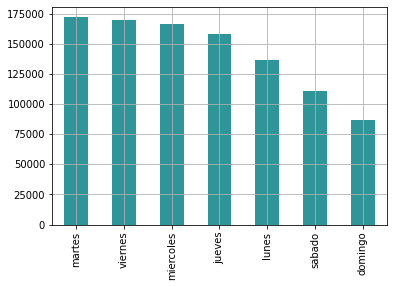

In [15]:
df['dia_semana'].value_counts().plot(kind='bar',grid=True, color='#2F9599');

In [16]:
# le asignamos un nuevo label al axis 0
orden = ["lunes", "martes", "miercoles", "jueves", "viernes", "sabado","domingo"]
df['dia_semana'].value_counts().reindex(orden)

lunes        136622
martes       171975
miercoles    166422
jueves       157923
viernes      169787
sabado       110854
domingo       86417
Name: dia_semana, dtype: int64

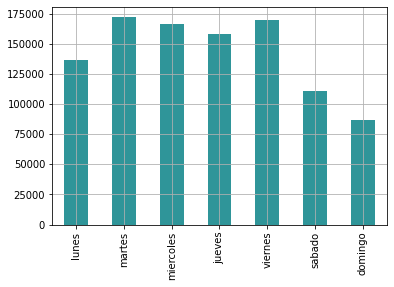

In [17]:
# y volvemos a plotear
df['dia_semana'].value_counts().reindex(orden).plot(kind='bar',grid=True, color='#2F9599');

In [18]:
# mes y año de inicio
df['start_mes'] = pd.to_datetime(df.start_date).dt.month
df['start_year'] = pd.to_datetime(df.start_date).dt.year

In [19]:
# vemos los años involucrados en la serie
df['start_year'].unique()

array([2021, 2020])

In [20]:
# nuestro indice podria ser anual. De marzo ...
df.loc[df['start_year']==2020].start_mes.unique()

array([ 5, 12, 11,  4, 10,  7,  6,  8,  3,  9])

In [21]:
# ... a marzo
df.loc[df['start_year']==2021].start_mes.unique()

array([1, 2, 3])

In [22]:
'{}-{}'.format(df['start_year'][0],df['start_mes'][0])

'2021-1'

In [23]:
# creamos una funcion para armar una etiqueta con el periodo mes/año
def etiqueta_aviso(x):
    fecha = '{}-{}'.format(x['start_year'],x['start_mes'])
    return fecha

Fíjense cómo aplicamos nuestra función regular. Sí! por medio de una función anónima.  Esta vez, el apply se aplica a todo el df. Por eso, esta vez, el place holder (x) no refiere a una serie o columna. La `x` ahora, es el dataframe. Por eso, nuestra función regular toma nombres de columnas. De este modo, es que también resulta necesario definir en qué sentido de los ejes será recorrido el dataframe. Nosotros ponemos 1, porque queremos ir recorriendo las filas de más de una columna a la vez.

In [24]:
# la aplicamos
df['etiqueta_fecha'] = df.apply(lambda x: etiqueta_aviso(x), axis=1)

In [25]:
df['etiqueta_fecha']

0         2021-1
1         2021-1
2         2021-1
3         2021-1
4         2021-1
           ...  
999995    2020-8
999996    2020-8
999997    2020-8
999998    2020-8
999999    2020-8
Name: etiqueta_fecha, Length: 1000000, dtype: object

In [26]:
# vemos cuales son los tipos de operación posibles
df.operation_type.unique()

array(['Venta', 'Alquiler', 'Alquiler temporal'], dtype=object)

In [27]:
# nos quedamos con los alquileres
alquileres = df.loc[df['operation_type']=='Alquiler']

### Construyendo series con tablas pivote 

> **pivot tables**

Las tablas pivot suelen ser muy utiles para sumarizar informacion. Mas alla de la implementacion de pandas, este es un recurso que atraviesa distintas herramientas.

Lo que hace esto, es basicamente transformar la forma (shape) de nuestro dataframe a partir de un valor que buscamos agregar. El metodo pivot_table permite especificar dicho valor y definir la funcion de agregacion (aggfunc) con la que lo vamos a sumarizar.

Veamos a continuacion que, para utilizar este metodo, pasamos un dataframe y definimos los values a ser sumarizados, los index y columns de nuestro nuevo marco de datos - pueden refrescar la digresion que hicimos en la clase anterior sobre axis - y la aggfunc. 

In [28]:
df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type', 'dia_semana',
       'start_mes', 'start_year', 'etiqueta_fecha'],
      dtype='object')

Exploremos nuestra variable de precios

In [29]:
# ya vemos algo raro
df['price'].max()

9999999999.0

In [30]:
# efectivamente, nunca filtramos nuestra base por geografía. Empecemos por argentina...
df['currency'].unique()

array(['USD', nan, 'ARS', 'UYU', 'PEN', 'COP'], dtype=object)

In [31]:
# nos quedamos con pesos argentinos
alquileres_arg = alquileres.loc[alquileres['currency']=='ARS'].copy()

In [32]:
# la media ya tiene un valor mas razonable, prosigamos
alquileres_arg.price.mean()

48370.398597696476

In [33]:
# creamos una tabla pivot
pivot_ = pd.pivot_table(alquileres_arg,
                        values="price",
                        index=alquileres_arg['etiqueta_fecha'], # se puede hacer en sentido del eje 0
                        #columns = aliquileres_arg['etiqueta_fecha'] # o del eje 1
                        aggfunc = 'mean',fill_value=0)

In [34]:
pivot_.head(2)

,price
etiqueta_fecha,
2020-10,58900.874455
2020-11,52053.061023


In [35]:
# veo si los puedo ordenar de menor a mayor
pivot_.sort_index(ascending=True).index

Index(['2020-10', '2020-11', '2020-12', '2020-3', '2020-4', '2020-5', '2020-6',
       '2020-7', '2020-8', '2020-9', '2021-1', '2021-2', '2021-3'],
      dtype='object', name='etiqueta_fecha')

In [36]:
# acomodamos un poco a mano
periodos_ordenados = ['2020-3', '2020-4', '2020-5', 
                      '2020-6','2020-7', '2020-8', '2020-9', 
                      '2020-10', '2020-11', '2020-12',
                      '2021-1', '2021-2', '2021-3']

In [37]:
# reindexamos
pivot_.reindex(periodos_ordenados)

,price
etiqueta_fecha,
2020-3,34984.959848
2020-4,38414.500304
2020-5,40542.037062
2020-6,40796.497548
2020-7,47150.341289
2020-8,44440.748174
2020-9,48371.718587
2020-10,58900.874455
2020-11,52053.061023


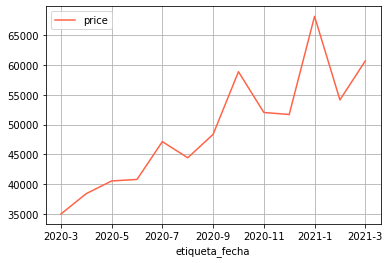

In [38]:
# y volvemos a plotear
pivot_.reindex(periodos_ordenados).plot(kind='line', grid=True, color='#FF6347');

Bueno, bien. Logramos construir una primera serie y plotearla. Tratemos de apuntar ahora a algo con un poco más de sentido conceptual. Este promedio que acabamos de construir no sólo no tiene en cuenta los efectos de la inflación sino también los tipos de productos considerados.

Tratemos de ser un poco más específicos. Determinemos alguna región, tipo de producto y, para terminar, intentemos deflacionar nuestra serie.

### Deflactando series

Para deflactar una serie de valores nominales, es necesario contar con alguna referencia. La traducción de valores nominales a reales (o corrientes y constantes), contempla el uso de un índice que nos permita evaluar cómo se comportaron los precios (o algunos) de la economía en relacion al poder adquisitivo. Para así, mitigar el impacto de la inflación en el bien que estamos estudiando. 

Por decirlo de alguna manera, vamos a tratar de expresar lo que vale un precio de un momento n+1 considerando a n como momento inicial. Cuánto vale algo en pesos de marzo 2021, por ejemplo.  

Lo primero con lo que vamos a trabajar es con el [IPC-Indec](https://www.indec.gob.ar/indec/web/Nivel4-Tema-3-5-31). 

Vamos a seleccionar la Región GBA y a buscar alguna apertura que nos interese para seguir estudiando los precios de los alquileres. Seleccionemos primero nuestra región.

In [39]:
# disponemos de los siguientes niveles administrativos
alquileres_arg.l2.unique()

array(['Bs.As. G.B.A. Zona Oeste', 'Capital Federal', 'Mendoza',
       'Buenos Aires Costa Atlántica', 'Salta',
       'Bs.As. G.B.A. Zona Norte', 'Santa Fe', 'Córdoba',
       'Bs.As. G.B.A. Zona Sur', 'Río Negro', 'Chaco', 'Tucumán',
       'Entre Ríos', 'Buenos Aires Interior', 'La Pampa', 'Misiones',
       'Neuquén', 'Montevideo', 'San Luis', 'Maldonado', 'Chubut',
       'Tierra Del Fuego', 'San Juan', 'Santa Cruz', 'Jujuy',
       'Corrientes', 'Colonia', 'La Rioja', 'São Paulo',
       'Santiago Del Estero', 'Catamarca', 'Formosa', 'Canelones'],
      dtype=object)

In [40]:
# nos quedamos con la Region GBA
jurisdicciones = ['Bs.As. G.B.A. Zona Oeste', 'Capital Federal',
                  'Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Sur']
alquileres_gba = alquileres_arg[alquileres_arg.l2.isin(jurisdicciones)]

In [41]:
# chequeamos el tipo de bien que vamos a estudiar
alquileres_gba.property_type.unique()

array(['Local comercial', 'Depósito', 'Oficina', 'Departamento', 'PH',
       'Casa', 'Cochera', 'Lote', 'Otro', 'Casa de campo'], dtype=object)

In [42]:
# quedemonos solamente con los departamentos
alquileres_gba = alquileres_gba[alquileres_gba.property_type.isin(['Departamento'])].copy()

#### El IPC - Indec

Listo, ya tenemos una serie de precios más depurada. Ahora trabajemos en acomodar nuestro índice de precios. El mismo está decargado en el el directorio de data del curso. Vemos cómo se ve...

In [43]:
!pip install xlrd

In [44]:
ipc_crudo = pd.read_excel('https://storage.googleapis.com/python_mdg/data_cursos/sh_ipc_aperturas.xls',
                           sheet_name='Variación mensual aperturas', header=None)

In [45]:
# hacemos slicing desde las filas 5 a la 53, el IPC para GBA
ipc_crudo = ipc_crudo.iloc[5:53].copy()

In [46]:
# renombramos columnas
ipc_crudo.columns = ipc_crudo.iloc[0]

In [47]:
ipc_indec = ipc_crudo.iloc[3:].copy()

In [48]:
ipc_indec.columns

Index([       'Región GBA', 2017-01-01 00:00:00, 2017-02-01 00:00:00,
       2017-03-01 00:00:00, 2017-04-01 00:00:00, 2017-05-01 00:00:00,
       2017-06-01 00:00:00, 2017-07-01 00:00:00, 2017-08-01 00:00:00,
       2017-09-01 00:00:00, 2017-10-01 00:00:00, 2017-11-01 00:00:00,
       2017-12-01 00:00:00, 2018-01-01 00:00:00, 2018-02-01 00:00:00,
       2018-03-01 00:00:00, 2018-04-01 00:00:00, 2018-05-01 00:00:00,
       2018-06-01 00:00:00, 2018-07-01 00:00:00, 2018-08-01 00:00:00,
       2018-09-01 00:00:00, 2018-10-01 00:00:00, 2018-11-01 00:00:00,
       2018-12-01 00:00:00, 2019-01-01 00:00:00, 2019-02-01 00:00:00,
       2019-03-01 00:00:00, 2019-04-01 00:00:00, 2019-05-01 00:00:00,
       2019-06-01 00:00:00, 2019-07-01 00:00:00, 2019-08-01 00:00:00,
       2019-09-01 00:00:00, 2019-10-01 00:00:00, 2019-11-01 00:00:00,
       2019-12-01 00:00:00, 2020-01-01 00:00:00, 2020-02-01 00:00:00,
       2020-03-01 00:00:00, 2020-04-01 00:00:00, 2020-05-01 00:00:00,
       2020-06-01 00

In [49]:
# listemos los metodos/atributos de la clase datetime
dir(datetime)

['__add__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rsub__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 'astimezone',
 'combine',
 'ctime',
 'date',
 'day',
 'dst',
 'fold',
 'fromisoformat',
 'fromordinal',
 'fromtimestamp',
 'hour',
 'isocalendar',
 'isoformat',
 'isoweekday',
 'max',
 'microsecond',
 'min',
 'minute',
 'month',
 'now',
 'replace',
 'resolution',
 'second',
 'strftime',
 'strptime',
 'time',
 'timestamp',
 'timetuple',
 'timetz',
 'today',
 'toordinal',
 'tzinfo',
 'tzname',
 'utcfromtimestamp',
 'utcnow',
 'utcoffset',
 'utctimetuple',
 'weekday',
 'year']

In [50]:
# armo de nuevo el nombre de las columnas
new_columns = []
for i in ipc_indec.columns:
    if i != 'Región GBA':
        y = i.year # el item que estamos iterando ya es un datetime!
        m = i.month
        fecha = '{}-{}'.format(y,m)
        new_columns.append(fecha)
    else:
        new_columns.append(i)

In [51]:
ipc_indec.columns = new_columns

In [52]:
# reseteamos nuestro indice
ipc_indec.reset_index(inplace=True)

In [53]:
# y borramos lo que era el previo
ipc_indec.drop(columns='index', inplace=True)

Ya tenemos nuestro IPC con las siguientes especificaciones. 

```
Índice de precios al consumidor con cobertura nacional. Resultados por región (GBA)

Período de referencia: Diciembre 2016=100

Variaciones mensuales de enero de 2017 a abril de 2021. Resultados según principales aperturas de la canasta
```

In [54]:
ipc_indec.head()

,Región GBA,2017-1,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,2017-9,...,2020-7,2020-8,2020-9,2020-10,2020-11,2020-12,2021-1,2021-2,2021-3,2021-4
0,Nivel general,1.3,2.5,2.4,2.6,1.3,1.4,1.7,1.5,2,...,1.6,2.8,2.8,3.6,3,3.7,3.3,3.6,5.2,4.1
1,Alimentos y bebidas no alcohólicas,1.3,1.8,3.5,2.3,1.1,1.3,1.2,2.2,1.9,...,1.3,3.7,2.8,4.8,2.1,2.8,4,4,4.9,4.7
2,Alimentos,1.3,2,3.7,2.3,1,1.3,1.1,2.3,1.7,...,1.2,3.7,3.3,5,2.2,3.1,4.2,4,5.4,4.7
3,Pan y cereales,1.5,2.2,2.8,2.1,0.9,1.9,1.8,1.2,1.1,...,2.1,1.8,2,2.6,2.8,1.2,1.9,3.9,3.7,5.7
4,Carnes y derivados,-1.1,0,5.4,2.5,1,-0.2,0.9,1,1.6,...,2.5,3.4,1.9,3.5,5.4,13.9,6.4,2.7,6.8,4.7


In [55]:
def aperturas_ipc_indec(df, rubro):
    aperturas = df.set_index('Región GBA')
    apertura_elegida = aperturas.loc[rubro]
    return apertura_elegida

In [56]:
# el IPC para cada periodo y apertura
aperturas_ipc_indec(ipc_indec, 'Alquiler de la vivienda')

2017-1     2.1
2017-2     2.8
2017-3       2
2017-4     2.2
2017-5     2.2
2017-6     2.2
2017-7     2.2
2017-8     2.1
2017-9     2.3
2017-10    1.6
2017-11    2.7
2017-12    2.2
2018-1     1.9
2018-2     2.8
2018-3     1.8
2018-4     1.8
2018-5     2.5
2018-6     2.8
2018-7     1.8
2018-8       2
2018-9     2.4
2018-10    1.8
2018-11    1.6
2018-12      2
2019-1     2.5
2019-2     2.4
2019-3     2.1
2019-4     2.9
2019-5     2.2
2019-6     2.2
2019-7     2.4
2019-8     2.8
2019-9     2.1
2019-10    2.4
2019-11    2.1
2019-12    1.7
2020-1     2.3
2020-2     2.7
2020-3     2.9
2020-4     1.2
2020-5    -0.2
2020-6     1.7
2020-7     0.7
2020-8     2.2
2020-9     1.5
2020-10    3.8
2020-11    2.4
2020-12    2.6
2021-1     3.1
2021-2     2.9
2021-3     2.8
2021-4     6.1
Name: Alquiler de la vivienda, dtype: object

Una vez que tenemos nuestro IPC limpio, listo para usar, no tenemos que perder de vista que el mismo va a ser aplicado a otro dataframe (nuestra tabla pivot con promedios nominales por período). 
Nosotros vamos a tomar el precio promedio para las operaciones de alquiler durante los últimos 12 meses desde marzo del corriente año. Es decir, de marzo de 2020 a marzo de 2021. 

In [57]:
# creamos una funcion para ajustar los pesos nominales por IPC
def deflactar_serie(x,y,z,ipc,rubro,ipc_indec=True):
    '''
    x (str): periodo  d
    '''
    # guardamos el periodo y su precio nominal
    periodo = x
    precio_nominal = y
    periodo_base = z

    if ipc_indec:
        # devuelve una serie con la variacion del rubro 
        serie = aperturas_ipc_indec(ipc, rubro)
    else:
        serie = ipc
    # seleccionamos el valor del índice para una apertura y periodo determinado
    ipc_periodo = serie.loc[periodo] 
    ipc_base = serie.loc[periodo_base]  
    coeficiente = ipc_periodo/ipc_base
    precio_constante = precio_nominal / coeficiente
    
    return periodo, precio_nominal, coeficiente, ipc_base, ipc_periodo, precio_constante


Preparemos ahora el dataset de alquileres, tenemos que quedarnos con sus periodos y el precio promedio para los casos del GBA.

In [58]:
# creamos nuestros promedios de precio por periodo para GBA
pivot_gba = pd.pivot_table(alquileres_gba,
                           values="price",
                           index=alquileres_gba['etiqueta_fecha'],
                           aggfunc = 'mean',fill_value=0)

In [59]:
pivot_gba.index

Index(['2020-10', '2020-11', '2020-12', '2020-3', '2020-4', '2020-5', '2020-6',
       '2020-7', '2020-8', '2020-9', '2021-1', '2021-2', '2021-3'],
      dtype='object', name='etiqueta_fecha')

In [60]:
# ajustamos un poco
periodos_ordenados = ['2020-3', '2020-4', '2020-5', '2020-6', 
                      '2020-7', '2020-8', '2020-9', '2020-10', 
                      '2020-11', '2020-12','2021-1', '2021-2', '2021-3']
gba_ordenado = pivot_gba.reindex(periodos_ordenados)

In [61]:
# y reseteamos el index
gba_ordenado.reset_index(inplace=True)

In [62]:
# renombamos columnas
gba_ordenado.columns = ['period', 'price']

In [63]:
gba_ordenado.set_index('period').loc['2020-3']

price    24093.55178
Name: 2020-3, dtype: float64

In [64]:
ipc_indec

,Región GBA,2017-1,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,2017-9,...,2020-7,2020-8,2020-9,2020-10,2020-11,2020-12,2021-1,2021-2,2021-3,2021-4
0,Nivel general,1.3,2.5,2.4,2.6,1.3,1.4,1.7,1.5,2,...,1.6,2.8,2.8,3.6,3,3.7,3.3,3.6,5.2,4.1
1,Alimentos y bebidas no alcohólicas,1.3,1.8,3.5,2.3,1.1,1.3,1.2,2.2,1.9,...,1.3,3.7,2.8,4.8,2.1,2.8,4,4,4.9,4.7
2,Alimentos,1.3,2,3.7,2.3,1,1.3,1.1,2.3,1.7,...,1.2,3.7,3.3,5,2.2,3.1,4.2,4,5.4,4.7
3,Pan y cereales,1.5,2.2,2.8,2.1,0.9,1.9,1.8,1.2,1.1,...,2.1,1.8,2,2.6,2.8,1.2,1.9,3.9,3.7,5.7
4,Carnes y derivados,-1.1,0,5.4,2.5,1,-0.2,0.9,1,1.6,...,2.5,3.4,1.9,3.5,5.4,13.9,6.4,2.7,6.8,4.7
5,"Leche, productos lácteos y huevos",2.2,3.1,2.6,5.3,2.4,3.6,1.8,0.8,0.8,...,1.5,2.2,-0.6,2.3,1.8,0.1,2.1,2.1,8.6,9.3
6,"Aceites, grasas y manteca",1.7,1.3,1.9,2.6,-0.1,1.1,4,1.7,1.6,...,1.6,3.3,0.9,4.2,3.5,1.1,2.3,2.5,6.4,7.9
7,Frutas,3.6,1,-2.2,-2.9,3.7,0.8,1.6,2,2.7,...,0.2,8.5,9.2,8.8,7.1,6.2,10.4,7.9,-1.8,-0.6
8,"Verduras, tubérculos y legumbres",4.7,6.9,7.7,0.8,-2.2,1.8,-2.1,12,3.3,...,-3.9,8.2,13.7,15.8,-6.8,-16.6,0.5,9.6,6.3,-0.9
9,"Azúcar, dulces, chocolate, golosinas, etc.",1.9,1,1.5,1.2,1.4,2.3,1.2,1.6,2,...,1,2.6,1.3,1.2,1.6,0.6,-0.1,3.4,1.7,4.9


In [65]:
# almacenamos nuestro resultado en una serie de tuplas
resultado = gba_ordenado.apply(lambda x: deflactar_serie(x.period, 
                                                         x.price,
                                                         '2020-3', # mes base 
                                                         ipc_indec, 
                                                         'Nivel general'), 
                               axis=1)

In [66]:
resultado

0     (2020-3, 24093.551779935275, 1.0, 3.6, 3.6, 24...
1     (2020-4, 22065.433749496577, 0.388888888888888...
2     (2020-5, 24948.104435219575, 0.416666666666666...
3     (2020-6, 26400.37637521714, 0.5555555555555556...
4     (2020-7, 28293.42228335626, 0.4444444444444445...
5     (2020-8, 29183.892293744335, 0.777777777777777...
6     (2020-9, 31377.165832870112, 0.777777777777777...
7     (2020-10, 33048.74170755643, 1.0, 3.6, 3.6, 33...
8     (2020-11, 39829.29230769231, 0.833333333333333...
9     (2020-12, 34224.7983135825, 1.027777777777778,...
10    (2021-1, 35634.759234653204, 0.916666666666666...
11    (2021-2, 37921.22598073761, 1.0, 3.6, 3.6, 379...
12    (2021-3, 42393.289300511824, 1.444444444444444...
dtype: object

In [67]:
# guardamos el resultado
serie_ajustada = resultado.apply(pd.Series)

# renombramos las columnas
columnas = ['periodo', 'precio_nom', 'coeficiente', 'ipc_base', 'ipc_per', 'precio_con']
serie_ajustada.columns = columnas

In [68]:
serie_ajustada

,periodo,precio_nom,coeficiente,ipc_base,ipc_per,precio_con
0,2020-3,24093.551780,1.000000,3.6,3.6,24093.551780
1,2020-4,22065.433749,0.388889,3.6,1.4,56739.686784
2,2020-5,24948.104435,0.416667,3.6,1.5,59875.450645
3,2020-6,26400.376375,0.555556,3.6,2.0,47520.677475
4,2020-7,28293.422283,0.444444,3.6,1.6,63660.200138
5,2020-8,29183.892294,0.777778,3.6,2.8,37522.147235
6,2020-9,31377.165833,0.777778,3.6,2.8,40342.070357
7,2020-10,33048.741708,1.000000,3.6,3.6,33048.741708
8,2020-11,39829.292308,0.833333,3.6,3.0,47795.150769
9,2020-12,34224.798314,1.027778,3.6,3.7,33299.803765


In [69]:
from matplotlib import pyplot as plt # importan la clase pyplot de matplotlib

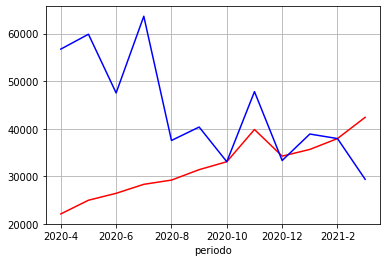

In [70]:
# ahora, creemos una figura (este tema lo van a retomar en la clase de visualizacion!)
fig, ax = plt.subplots()
serie_ajustada.iloc[1:].set_index('periodo')['precio_nom'].plot(kind='line', grid=True, color='r')
serie_ajustada.iloc[1:].set_index('periodo')['precio_con'].plot(kind='line', grid=True, color='b');

La evolución del precio promedio para departamentos en alquiler de la Región GBA. En azul, los precios en base a marzo de 2020 (pesos de ese mes/año). En azul, los precios nominales.

In [71]:
# creamos algunas series para ver cuánto variaron de año a año en términos porcentuales
serie_ajustada['pct_nom']=serie_ajustada['precio_nom'].pct_change() * 100
serie_ajustada['pct_con']=serie_ajustada['precio_con'].pct_change() * 100
serie_ajustada['pct_ipc']=serie_ajustada['ipc_per'].pct_change() * 100

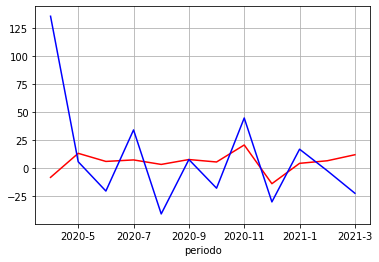

In [72]:
# y ploteamos!
fig, ax = plt.subplots()
serie_ajustada.iloc[0:].set_index('periodo')['pct_nom'].plot(kind='line', grid=True, color='r',ax=ax)
serie_ajustada.iloc[0:].set_index('periodo')['pct_con'].plot(kind='line', grid=True, color='b', ax=ax);

Vemos algunas cosas acá. Ahora bien, es correcto ajustar asi?, considerando sólo el coportamiento de los precios y no de los ingresos? sobretodo si vemos cómo funciona nuestro índice a lo largo del tiempo ...

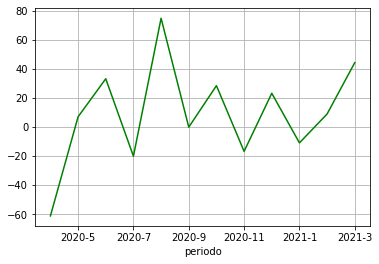

In [73]:
serie_ajustada.iloc[0:].set_index('periodo')['pct_ipc'].plot(kind='line', grid=True, color='g');

#### El ICL - BCRA

Ahora bien, el índice que estamos usando solamente contempla el impacto de los precios (la variacion de los bienes ofertados). Como que nos falta algo para poder ajustar y que el grafico tenga mas sentido.

Para tener un análisis un poco más completo, deberíamos incluir de alguna manera cómo evolucionó también el poder de compra o pago de los salarios. 

Un muy buen atajo podría ser, en lugar construir una serie de ingresos y combinar con el IPC, utilizar el ICL. El índice de Contratos de Locación.

[Desde agosto de 2020, con la sanción de la Nueva Ley de Alquileres](https://www.argentina.gob.ar/noticias/el-bcra-oficializo-el-metodo-para-calcular-el-ajuste-anual-de-los-alquileres), los contratos de alquiler de los inmuebles destinados a uso habitacional se ajustan anualmente. El indice para hacerlo es el ICL, que podemos indagar en la web del [BCRA](http://bcra.gob.ar/PublicacionesEstadisticas/Principales_variables.asp)

In [74]:
icl_bcra = pd.read_excel('https://storage.googleapis.com/python_mdg/data_cursos/indice_contratos_locacion.xls')

In [75]:
icl_bcra['Mes'] = icl_bcra.Fecha.apply(lambda x: x.split('/')[2] + '-' + x.split('/')[1]) 

In [76]:
# reemplazamos las comas y convertimos nuestro valores en float
icl_bcra['Valor'] = icl_bcra['Valor'].str.replace(',', '.', regex=False)
icl_bcra['Valor'] = icl_bcra.Valor.apply(lambda x: float(x))

In [77]:
icl_bcra = icl_bcra.drop_duplicates(subset='Mes', keep='last')

In [78]:
icl_bcra = icl_bcra[['Valor','Mes']].set_index('Mes')

In [79]:
# renombramos nuestro indice, para que matchee con nuestra serie de valores
icl_bcra.index = icl_bcra.index.str.replace('-0', '-', regex=False)

In [80]:
# asi tenemos que pasar el indice
icl_bcra['Valor']

Mes
2020-7     1.01
2020-8     1.02
2020-9     1.05
2020-10    1.07
2020-11    1.09
2020-12    1.13
2021-1     1.16
2021-2     1.19
2021-3     1.21
Name: Valor, dtype: float64

In [81]:
# como nuestro indice empieza en julio, recortamos nuestra serie nominal desde ahi
gba_ordenado_ = gba_ordenado.set_index('period').loc['2020-7':].reset_index()
resultado = gba_ordenado_.apply(lambda x: deflactar_serie(x.period, 
                                                         x.price,
                                                         '2020-7', # mes base 
                                                         icl_bcra.Valor, 
                                                         'Nivel general',
                                                         ipc_indec=False), 
                                axis=1)

In [82]:
# hacemos las mismas transformaciones que hicimos antes para acomodar las tuplas
serie_ajustada = resultado.apply(pd.Series)
columnas = ['periodo', 'precio_nom', 'coeficiente', 'ipc_base', 'ipc_per', 'precio_con']
serie_ajustada.columns = columnas

In [83]:
# el idice es mucho menos brusco que el anterior
serie_ajustada

,periodo,precio_nom,coeficiente,ipc_base,ipc_per,precio_con
0,2020-7,28293.422283,1.000000,1.01,1.01,28293.422283
1,2020-8,29183.892294,1.009901,1.01,1.02,28897.775703
2,2020-9,31377.165833,1.039604,1.01,1.05,30181.845230
3,2020-10,33048.741708,1.059406,1.01,1.07,31195.541238
4,2020-11,39829.292308,1.079208,1.01,1.09,36906.041496
5,2020-12,34224.798314,1.118812,1.01,1.13,30590.306457
6,2021-1,35634.759235,1.148515,1.01,1.16,31026.816230
7,2021-2,37921.225981,1.178218,1.01,1.19,32185.242219
8,2021-3,42393.289301,1.198020,1.01,1.21,35386.134044


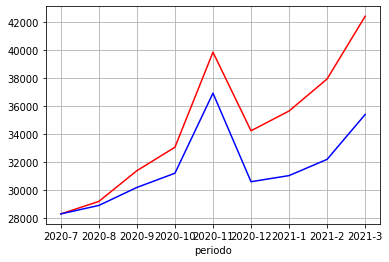

In [84]:
fig, ax = plt.subplots()
serie_ajustada.set_index('periodo')['precio_nom'].plot(kind='line', grid=True, color='r');
serie_ajustada.set_index('periodo')['precio_con'].plot(kind='line', grid=True, color='b');

Ahora si, nuestros precios deflactados. Se puede apreciar que la serie ajustada por ICL es más suave que la nominal.

In [85]:
serie_ajustada['pct_nom']=serie_ajustada['precio_nom'].pct_change() * 100
serie_ajustada['pct_con']=serie_ajustada['precio_con'].pct_change() * 100
serie_ajustada['pct_ipc']=serie_ajustada['ipc_per'].pct_change() * 100

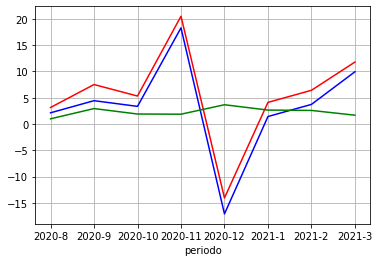

In [86]:
fig, ax = plt.subplots()
serie_ajustada.set_index('periodo')['pct_nom'].plot(kind='line', grid=True, color='r',ax=ax)
serie_ajustada.set_index('periodo')['pct_con'].plot(kind='line', grid=True, color='b', ax=ax)
serie_ajustada.set_index('periodo')['pct_ipc'].plot(kind='line', grid=True, color='g', ax=ax);

Confirmamos lo anterior, el cambio porcentual de los precios constantes fue un poco más bajo que el nominal. En verde, se aprecia cómo el ICL es mucho más suave que el IPC.

## Ejercicio sugerido (con solución)

> 1. **Armar con una tabla pivot el precio promedio por período para las distintas jurisdicciones que contemplamos para GBA.**

In [87]:
# con una tabla pivot podemos obtener los promedios para todas las jurisdicciones
alquileres_gba_region = pd.pivot_table(alquileres_gba,
                                       values="price",
                                       index=alquileres_gba['etiqueta_fecha'],
                                       columns=alquileres_gba['l2'], # la jurisdiccion! 
                                       aggfunc = 'mean',fill_value=0)

In [88]:
# lo pueden ver aca
alquileres_gba_region.head()

l2,Bs.As. G.B.A. Zona Norte,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal
etiqueta_fecha,,,,
2020-10,30335.921053,17756.920078,30550.673121,37158.711957
2020-11,50792.023634,19130.585683,29361.546061,43569.689072
2020-12,38565.781250,19287.587822,26448.226721,37853.635271
2020-3,24255.468750,13359.649123,14513.513514,28505.406844
2020-4,27967.733990,12275.172414,14647.167868,31435.504902


Entonces, algo que podríamos hacer es crear una función para seleccionar regiones de a una, y de paso, acomodar el dataframe a como sabemos que lo vamos a necesitar.

In [89]:
# nuestra función para seleccionar regiones
def seleccionar_region(region):
    
    '''
    Selecciona una columna, siendo esta la region y sus precios
    en el df "alquileres_gba_region".
    '''
    periodos_ordenados = ['2020-3', '2020-4', '2020-5', '2020-6', 
                          '2020-7', '2020-8', '2020-9', '2020-10', 
                          '2020-11', '2020-12','2021-1', '2021-2', '2021-3']
    gba_regiones = alquileres_gba_region.reindex(periodos_ordenados)
    gba_regiones.reset_index(inplace=True)

    gba_region = gba_regiones[['etiqueta_fecha',region]].copy()

    gba_region.columns = ['period', 'price']
    return gba_region

In [90]:
# podríamos empezar trabajando con zona norte
seleccionar_region('Bs.As. G.B.A. Zona Norte')

,period,price
0,2020-3,24255.468750
1,2020-4,27967.733990
2,2020-5,27850.062189
3,2020-6,25608.593750
4,2020-7,30268.864629
5,2020-8,29069.827586
6,2020-9,32167.431694
7,2020-10,30335.921053
8,2020-11,50792.023634
9,2020-12,38565.781250


In [91]:
# instanciamos zona norte
zona_norte = seleccionar_region('Bs.As. G.B.A. Zona Norte')

> **2. Elijan una región y calculen precios constantes. Si lo hacen por el camino indec deberan conseguir una serie de ingresos (puede ser por EPH, u otro mecanismo) para terminar de construir un indice.**

Como vimos en clase con el ICL, para deflactar, además de una medida que nos hable de precios debemos tener en cuenta la evolución de los ingresos. Entonces:

*2.1. Si deflactaramos por `icl`, no haría falta hacer ningún proceso adicional.*

*2.2. Si quisieramos usar el `ipc_indec` que construimos para GBA, deberíamos incorporar también una serie de ingresos.*

Como `2.1.` no nos insume ningún otro esfuerzo mas que volver a correr el notebook y cambiar las regiones, vamos a ir por `2.2.`. Tanto para alargar la serie deflactada como para agregar recursos adicionales que les queden disponibles.


Hasta ahora, nuestro ipc nos dice las variaciones porcentuales de los distintos bienes de la economía mes a mes (tomando como referencia un periodo de base). Esto deberíamos combinarlo con una serie salarial y armar un índice o coeficiente único.

Para hacer esto podríamos trabajar tanto con valores salariales como con variaciones porcentuales. A continuación les dejo algunos links donde pueden buscar referencias para construir series de salario:

**a)** La remuneración imponible promedio de los trabajadores estables - [RIPTE](https://www.argentina.gob.ar/trabajo/seguridadsocial/ripte)

**b)** Ministerio de Trabajo - [estadísticas](http://www.trabajo.gob.ar/estadisticas/Bel/ingresos.asp). Este portal incluye varias alternativas, desde construcciones trimestrales por EPH/EAHU hasta negociaciones colectivas.

**c)** Subsecretaría de Programación Macroeconómica de la Nación. Muchos de sus datasets están subidos al portal de datos `datos.gob.ar`.

Yo voy a ir por la opción `c` y voy a trabajar con [este dataset](https://datos.gob.ar/dataset/sspm-indice-salarios-base-octubre-2016/archivo/sspm_149.1) que ya está subido al directorio `data` del curso.

Entonces lo que voy a hacer es tratar de combinar el índice de salarios (que nos indica sus variaciones porcentuales a lo largo de los meses) con el índice de precios.

Para eso, primero cargamos el dataset en cuestión.

In [92]:
# indice de salarios
salarios = pd.read_csv('https://storage.googleapis.com/python_mdg/data_cursos/indice-salarios-periodicidad-mensual-base-octubre-2016.csv')

In [93]:
salarios.head()

,indice_tiempo,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,indice_salarios_no_registrado_sector_privado
0,2015-10-01,NaN,74.44,73.97,75.24,NaN
1,2015-11-01,NaN,76.07,75.95,76.28,NaN
2,2015-12-01,NaN,77.29,77.36,77.18,NaN
3,2016-01-01,NaN,78.38,78.93,77.46,NaN
4,2016-02-01,NaN,79.42,80.04,78.36,NaN


Ahora, lo que vamos a tener que hacer es ajustar nuestro deflactor considerando dos escenarios: si pasamos un deflactor o indice ya listo para deflactar, o si pasamos un indice de precios y salarios para construir un nuevo indice o coeficiente.

Empecemos por armar una función que nos formatee nuestra sere de índices salariales

In [94]:
# creamos una función para formatear nuestra serie de salarios
def formatea_isa(isa, serie='indice_salarios'):
    
    '''
    Formatea dataframe con indice de precios
    ...
    isa(df): indice de salarios - ver formato en dataframe
    serie(str): default con el nombre de la serie a utilizar 
                Nota: podrian elegir otra columna, para ello deberían cambiar
                      el valor del default cuando ejecutan la función indicando
                      el nombre de otra de las columnas disponibles!

    Devuelve:
    pandas.Series: serie con indice de salarios emparejado al año base del IPC
    '''
    # hacemos slicing sobre los strings de fecha para quedarnos con el periodo
    isa['periodo'] = isa.indice_tiempo.apply(lambda x: x[:7])
    # filtramos desde el periodo de referencia (octubre de 2016)
    isa_f = isa.set_index('periodo').loc['2016-10':].copy()
    # como nuestro ipc esta en base dicimiebre 2016, vamos a llevar el isa al mismo periodo
    isa_f.drop(columns='indice_tiempo', inplace=True) 

    # filtramos nuestro isa en base al periodo disponible del ipc,
    # esto se podría parametrizar en función de esa disponibilidad. Pero dejemoslo así, simple.
    isa_rebase = isa_f.apply(lambda x: x/isa_f.loc['2016-12'], axis=1)
    # renombramos los periodos para ajustar el formato que traemos de antes
    isa_rebase.index = isa_rebase.index.str.replace('-0', '-', regex=False)
    # nuestro ipc va de enero 2017 en adelante, hacemos slicing desde ahi
    isa_rebase = isa_rebase.loc['2017-1':].copy()
    return isa_rebase[serie]

In [95]:
# aca nuestro indice de salarios formateado
formatea_isa(salarios).head()

periodo
2017-1    1.015468
2017-2    1.028894
2017-3    1.058663
2017-4    1.095729
2017-5    1.113241
Name: indice_salarios, dtype: float64

Ahora que tenemos un índice de salarios listo tenemos que incorporar las modificaciones que mencionamos más arriba. Hacer que la función deflactora pueda trabajar con índices ya listos como el ICL, o bien, con índices que tienen que ser construidos. Para ello, incoroporemos la posibilidad de crear un nuevo índice a partir de salarios y precios:

In [96]:
# vamos a ajustar un poco el codigo de nuestro deflactor para ajustarnos a la consigna
def deflactar_serie(pe,pr,ba, # en primer lugar, fijense que renombramos varios parametros
                    construye_d=True,
                    ipc=ipc_indec,
                    isa=salarios,
                    rubro_ipc='Nivel general',
                    rubro_isa='indice_salarios',
                    d=None,):
    
    '''
    Deflacta una serie de valores nominales
    ...
    pe(str): nombre de la serie con la etiqueta del periodo nominal
    pr(str): nombre de la serie con valores nominales
    ba(str): nombre del periodo que vamos a tomar como base
    construye_d(bool): construir el deflactor en el cuerpo de la funcion (e.g:False)
                       Nota alumnos: este parametro es default, si no lo especifican
                       a la hora de ejecutar la funcion se va a tomar True como valor.
    ipc(serie): serie de pandas con variaciones porcentuales de precios
    isa(serie): serie de pandas con variaciones porcentuales de salarios
    rubro_ipc(str): nombre de la apertura del ipc. El default es 'Nivel general', pero
                    también se puede cambiar cuando se ejecuta la función.
    rubro_isa(str): nombre del tipo de indice salarial de referencia. El default también
                    se puede cambiar por otro nombre.
    d(str): serie de pandas con un índice deflactor.
    Devuelve:
    pd.Series: Serie de tuplas.
    '''
    periodo = pe
    precio_nominal = pr
    periodo_base = ba

    if construye_d: # si esto evalua a True, 
        precios = aperturas_ipc_indec(ipc, rubro_ipc)
        salarios = formatea_isa(isa, rubro_isa)
        serie = salarios/precios.mean() # entonces construimos nuestro deflactor,
                                        # en nuestro caso expresamos las variaciones mensuales
                                        # de los salarios en función del promedio de las
                                        # variaciones de precios
    else:
        serie = d # sino, usamos uno ya armado (como el ICL)

    # en esta seccion deflactamos
    serie_periodo = serie.loc[periodo] 
    serie_base = serie.loc[periodo_base]  
    coeficiente = serie_periodo/serie_base
    precio_constante = precio_nominal / coeficiente

    return periodo, precio_nominal, coeficiente, serie_base, serie_periodo, precio_constante

Antes de aplicar nuestra función, un comentario sobre su uso. Si en lugar de haber hecho:

```
return periodo, precio_nominal, coeficiente, ipc_base, ipc_periodo, precio_constante
```

hubiésemos hecho solamente:

```
return precio_nominal
```

... esto nos habría permitido aplicar nuestra función directamente al dataframe original. Si, aquel que descargamos de properati y tenía alrededor de un millón de registros. Eso hubiese servido para crear una columna o serie de precios constantes allí mismo. Así:

```
df['price_constant'] = df.apply(lambda x: ...)
```

Pero como nuestro objetivo es otro (queremos ver esa serie de tuplas con todos los indicadores que construimos), vamos a simplemente dejarlo como está y ver qué resultado obtenemos para zona norte:

In [97]:
zona_norte

,period,price
0,2020-3,24255.468750
1,2020-4,27967.733990
2,2020-5,27850.062189
3,2020-6,25608.593750
4,2020-7,30268.864629
5,2020-8,29069.827586
6,2020-9,32167.431694
7,2020-10,30335.921053
8,2020-11,50792.023634
9,2020-12,38565.781250


In [98]:
res_zn = zona_norte.apply(lambda x: deflactar_serie(pe=x.period, 
                                           pr=x.price,
                                           ba='2020-3',  
                                           rubro_ipc='Alquiler de la vivienda'), 
                          axis=1)

zn_ajustada = res_zn.apply(pd.Series)
zn_columnas = ['periodo', 'precio_nom', 'coeficiente', 'ipc_base', 'ipc_per', 'precio_con']
zn_ajustada.columns = zn_columnas

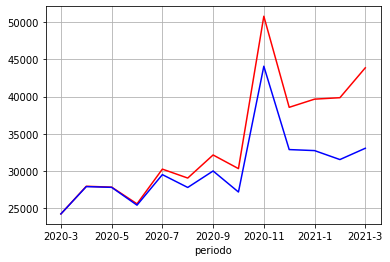

In [99]:
fig, ax = plt.subplots()
zn_ajustada.set_index('periodo')['precio_nom'].plot(kind='line', grid=True, color='r')
zn_ajustada.set_index('periodo')['precio_con'].plot(kind='line', grid=True, color='b');

> **3. Comparen esa serie con la serie de precios constantes para todo GBA (la que calculamos antes del ejercicio) - también se puede hacer la comparación con otra jurisdicción!**

Listo, lo que acabamos de hacer nos permitiría también comparar el comportamiento de los alquileres con otras jurisdicciones, por ejemplo, zona sur. Calculemosla.

In [100]:
zona_sur = seleccionar_region('Bs.As. G.B.A. Zona Sur')

res_zs = zona_sur.apply(lambda x: deflactar_serie(pe=x.period, 
                                                  pr=x.price,
                                                  ba='2020-3',  
                                                  rubro_ipc='Alquiler de la vivienda'), 
                        axis=1)

zs_ajustada = res_zs.apply(pd.Series)
zs_columnas = ['periodo', 'precio_nom', 'coeficiente', 'ipc_base', 'ipc_per', 'precio_con']
zs_ajustada.columns = zn_columnas

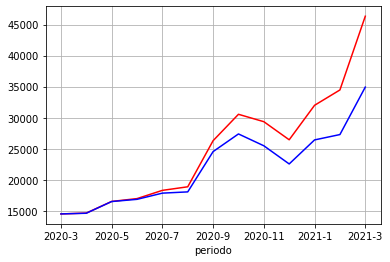

In [101]:
# así quedarían los precios nominales y reales en zona sur
fig, ax = plt.subplots()
zs_ajustada.set_index('periodo')['precio_nom'].plot(kind='line', grid=True, color='r')
zs_ajustada.set_index('periodo')['precio_con'].plot(kind='line', grid=True, color='b');

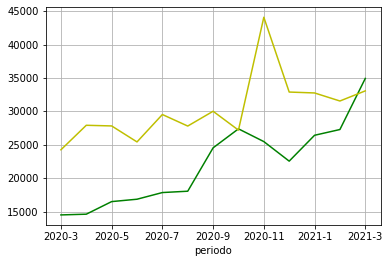

In [102]:
# así los precios constantes en zona norte y zona sur!
fig, ax = plt.subplots()
zs_ajustada.set_index('periodo')['precio_con'].plot(kind='line', grid=True, color='g')
zn_ajustada.set_index('periodo')['precio_con'].plot(kind='line', grid=True, color='y');

In [103]:
res_gba = gba_ordenado.apply(lambda x: deflactar_serie(pe=x.period, 
                                                       pr=x.price,
                                                       ba='2020-3',  
                                                       rubro_ipc='Alquiler de la vivienda'), 
                             axis=1)

gba_ajustada = res_gba.apply(pd.Series)
gba_columnas = ['periodo', 'precio_nom', 'coeficiente', 'ipc_base', 'ipc_per', 'precio_con']
gba_ajustada.columns = gba_columnas

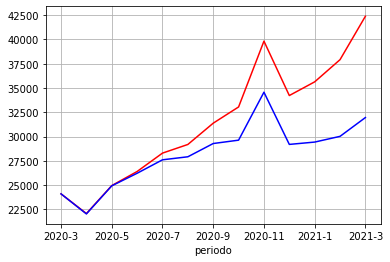

In [104]:
# nuestros precios nominales y reales en todo el GBA
fig, ax = plt.subplots()
gba_ajustada.set_index('periodo')['precio_nom'].plot(kind='line', grid=True, color='r')
gba_ajustada.set_index('periodo')['precio_con'].plot(kind='line', grid=True, color='b');

Ahora sí, el último paso. Comparemos las series constantes de Zona Norte y Sur, contextualizando vs la región GBA.

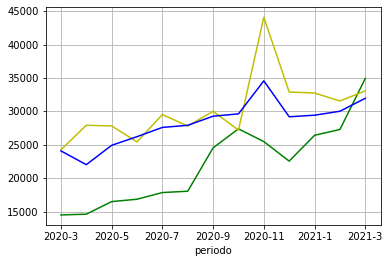

In [105]:
# los precios constantes en contexto!
fig, ax = plt.subplots()
zs_ajustada.set_index('periodo')['precio_con'].plot(kind='line', grid=True, color='g')
zn_ajustada.set_index('periodo')['precio_con'].plot(kind='line', grid=True, color='y')
gba_ajustada.set_index('periodo')['precio_con'].plot(kind='line', grid=True, color='b');